<a href="https://colab.research.google.com/github/zhhhling/RiskLimitingDispatch/blob/main/0_05variation_118bus_rld_neural_policy_learn_theta_directly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 30 18:20:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## utils.py

In [3]:
import os, time
import cvxpy as cp
import random
from numpy import savetxt
import argparse
import json
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable

In [4]:
def create_dir(PATH):
    isExist = os.path.exists(PATH)

    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(PATH)
        print("The new directory is created!")

In [5]:
# Evaluate using vector distance
def measure_relative_distance(v1, v2):
    '''
        Note that v1 is the benchmark.
        Norm is calculated along dimension/axis 1
        and average is calculated along dimension/axis 0
    '''
    if len(v1.shape)==1 and len(v2.shape)==1:
        distance = np.abs(v1-v2)/np.abs(v1)

    if len(v1.shape)==2 and len(v2.shape)==2:
        distance = np.linalg.norm(v1-v2, axis=1)/np.linalg.norm(v1, axis=1)

    return np.mean(distance)

In [6]:
def identify_unique_lines(connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count+=1

    # This code snippet only finds out the repeated lines with exactly the same order of nodes,
    # but not deal with that [i,j] and [j,i] are also repeated lines
    # By checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k]=val
    print('unique_lines length:', len(unique_lines))

    repeated_lines = [[42, 49],[49, 54],[56, 59],[49, 66],[77, 80],[89, 90],[89, 92]]
    # For example, [42, 49] appears twice
    set1 = {}
    set2 = {}
    for k, val in all_lines.items():
        if val in repeated_lines and k in unique_lines:
            set1[val[0], val[1]] = k # Record the repeated lines when they first appear
        if val in repeated_lines and k not in unique_lines:
            set2[val[0], val[1]] = k # Record the repeated lines when they appear more than once

    # print('set1:', len(set1))
    # print('set2:', len(set2))

    return unique_lines, set1, set2

In [7]:
def get_Y():
    N = num_buses
    Y = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i==j : 
                Y[i,j] = sum(B[i,:])
            else: 
                Y[i,j] = -B[i,j]

    return Y[:,1:]

def get_A():
    N = num_buses
    L = num_lines 
    A = np.zeros((L, N))

    for i, line in enumerate(connections):
        row = line[0]-1
        col = line[1]-1
        A[i, row] = B[row,col]
        A[i, col] = -B[row,col]

    return A[:,1:]


## models.py



```
ReLUNet
tanhNet
LReLUNet
```



In [94]:
class ActionNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ActionNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        # self.linear4 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)


    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # x = torch.tanh(self.linear1(input))
        # x = torch.tanh(self.linear2(x))
        # x = torch.tanh(self.linear3(x))
        # x = torch.tanh(self.linear4(x))
        # y_pred = torch.tanh(self.linear5(x))

        x = F.relu(self.linear1(input))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = F.relu(self.linear3(x))
        x = self.dropout(x)
        # x = F.relu(self.linear4(x))
        # x = self.dropout(x)
        y_pred = F.relu(self.linear4(x))


        return y_pred

In [9]:
class RewardNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(RewardNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, H)
        self.linear5 = torch.nn.Linear(H, D_out)

        # # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
       
        x = F.relu(self.linear1(input))
        # x = self.dropout(x)
        x = F.relu(self.linear2(x))
        # x = self.dropout(x)
        x = F.relu(self.linear3(x))
        # x = self.dropout(x)
        x = F.relu(self.linear4(x))
        # x = self.dropout(x)
        y_pred = torch.tanh(self.linear5(x))


        return y_pred

In [10]:
class TrainDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
	# must override two of the subclass functions:
    def __len__(self):
        # return len(self.samples)
        return self.samples.shape[0]

    def __getitem__(self, idx):
        # return self.samples[idx]
        return self.samples[idx,:]

In [11]:
def init_weights(m):
    if isinstance(m, nn.Linear):

        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0.01)
        # m.bias.data.uniform_(0, y)

        # torch.nn.init.xavier_uniform_(m.weight)
        # m.bias.data.fill_(0.01)

## To use
# # Initialize
# net.apply(init_weights)

## gauge.py


In [12]:
def gauge_function(V, G, H):
    """
    The gauge function of the vector z w.r.t. the set P
    is given by the following code.

    V can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    
    """
    # return torch.max(G@V/H,dim = 0).values # shape(output) = (1, K)

    # torch.div() for element-wide division
    return torch.max(torch.div(G@V, H),dim = 0).values # shape(output) = (1, K)

def gauge_map(Z, G, H):
    """
    For any Z \belongsto B_infinity, the gauge map from B_infinity to the set P
    defined by {v: G@v <= h} is given by the following code.
    
    Z can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    """

    gamma_dest = gauge_function(Z, G, H)# shape = (1, K)
    # print('gamma_dest:', gamma_dest)
    gamma_start = torch.linalg.norm(Z, ord = np.inf, dim=0) # shape(1, K)

    scaling_mat = torch.diag(gamma_start/gamma_dest) # shape = (K, K)

    return Z@scaling_mat # shape = (r, K), this is the new point in P

## Paths are defined here

In [13]:
params_path = './gdrive/MyDrive/Inbox/rld_neural_policy/118bus/params/'
data_path = './gdrive/MyDrive/Inbox/rld_neural_policy/118bus/data/'

saved_path = './gdrive/MyDrive/Inbox/rld_neural_policy/118bus/saved_main/'
isExist = os.path.exists(saved_path)

if not isExist:
    # Create a new directory if it does not exist 
    os.makedirs(saved_path)

## Import 118bus system (118bus.py)





In [14]:
bus_data_fname = '118bus_BusData.csv'
gen_data_fname = '118bus_GenData.csv'

branch_data_fname = '118bus_BranchData.csv'
cost_data_fname = '118bus_CostData.csv'

bus_data_df = pd.read_csv(params_path+bus_data_fname,header=None)
gen_data_df = pd.read_csv(params_path+gen_data_fname,header=None)
branch_data_df = pd.read_csv(params_path+branch_data_fname,header=None)
cost_data_df = pd.read_csv(params_path+cost_data_fname,header=None)

# display(bus_data_df)
# display(gen_data_df)
# display(branch_data_df)
# display(cost_data_df)

num_buses = bus_data_df.shape[0]
num_lines = branch_data_df.shape[0]
num_gens = gen_data_df.shape[0]

print('num_buses:', num_buses)
print('num_lines:', num_lines)
print('num_gens:', num_gens)

bus_data = bus_data_df.to_numpy()
gen_data = gen_data_df.to_numpy()
branch_data = branch_data_df.to_numpy()
cost_data = cost_data_df.to_numpy()

x = branch_data[:,3]
# print('x:')
# display(pd.DataFrame(x))
print('max of x:', max(x))
print('min of x:', min(x))


b = 1/x
# print('b:')
Z0 = 10
b = b/Z0
# display(pd.DataFrame(b))
print('max of b:', max(b))
print('min of b:', min(b))

connections = []
branches = branch_data[:,:2]
for i in range(branches.shape[0]):
		connections.append([int(branches[i,0]),int(branches[i,1])])
print('len of connections:', len(connections))

unique_lines, set1, set2 = identify_unique_lines(connections)
# print('set1:', set1)
# print('set2:', set2)

B = np.zeros((num_buses, num_buses))
# for i, line in enumerate(connections):
for k, line in unique_lines.items():
    row = line[0]-1
    col = line[1]-1
    B[row, col] = b[k]
    B[col, row] = b[k]

# display(pd.DataFrame(B).head())

Yrr = get_Y()
Arr = get_A()

N = num_buses
L = num_lines 

G = np.block([
              [Arr],
              [-Arr],
              [np.eye(N-1)],
              [-np.eye(N-1)]
])
print('G shape:', G.shape)

ymax = 2
ymin = 0
Fmax = 2

PD = bus_data[:,2]/20
print('PD:')
display(pd.DataFrame(PD))
# PD_data = PD.to_numpy()
PD_data = PD
print('Total PD:', sum(PD))

nominal_PD_data = PD_data.reshape(1,-1)



num_buses: 118
num_lines: 186
num_gens: 54
max of x: 0.411
min of x: 0.004
max of b: 25.0
min of b: 0.24330900243309003
len of connections: 186
unique_lines length: 179
G shape: (606, 117)
PD:


,0
0,2.55
1,1.00
2,1.95
3,1.95
4,0.00
...,...
113,0.40
114,1.10
115,9.20
116,1.00


Total PD: 212.10000000000005


## Load cost coefficients

In [15]:
def load_cost_coeff():    
    quad_cost_coeff = np.load(params_path+'quad_cost_coeff.npy')
    linear_cost_coeff = np.load(params_path+'linear_cost_coeff.npy')
    da_cost_coeff = np.load(params_path+'da_cost_coeff.npy')

    return quad_cost_coeff, linear_cost_coeff, da_cost_coeff

In [16]:
quad_cost_coeff, linear_cost_coeff, da_cost_coeff = load_cost_coeff() 

quad_cost_Coeff = np.diag(quad_cost_coeff)
linear_cost_Coeff = linear_cost_coeff.reshape(-1, 1)

da_cost_Coeff = da_cost_coeff.reshape(-1,1)

print('quad_cost_Coeff shape:', quad_cost_Coeff.shape)
print('linear_cost_Coeff shape:', linear_cost_Coeff.shape)
print('da_cost_Coeff shape:', da_cost_Coeff.shape)


quad_cost_Coeff shape: (118, 118)
linear_cost_Coeff shape: (118, 1)
da_cost_Coeff shape: (118, 1)


## Get train dataset prepared

In [17]:
# DataFlag = True

# num_points = 50000
# forecasts = nominal_PD_data.reshape(1,-1)

# scaling = 0.3
# lb = np.clip((1-scaling)*forecasts, a_min=0., a_max=None)
# ub = (1+scaling)*forecasts

# if DataFlag == True:

#     train_dataset = np.random.uniform(lb, ub, (num_points, N))
#     test_dataset = np.random.uniform(lb, ub, (100, N))

#     np.save(data_path+'train_set_point30.npy', train_dataset)
#     np.save(data_path+'test_set_point30.npy', test_dataset)


#     # Generate dataset for pretrain
#     random_rows = np.random.choice(num_points, 100)
#     pretrain_dataset = train_dataset[random_rows,:]
#     print('pretrain_dataset:', pretrain_dataset.shape)
#     # pretrain_dataset = np.random.uniform(lb, ub, (100, N))

#     np.save(data_path+'pretrain_dataset30.npy', pretrain_dataset)

# else:
#     train_dataset = np.load(data_path+'train_set_point30.npy')
#     test_dataset = np.load(data_path+'test_set_point30.npy')

#     pretrain_dataset = np.load(data_path+'pretrain_dataset30.npy')

#     test_dataset = test_dataset[:100,:]

# max_input_val = np.max(train_dataset)
# # Note that train_dataset and test_dataset are not normalized
# TrainSet = TrainDataset(train_dataset/max_input_val)
# TestSet = TrainDataset(test_dataset/max_input_val)

# Pe = 'gaussian'
# ratio = 0.05
# sigma = 0.05

In [18]:
DataFlag = False

num_points = 50000
forecasts = nominal_PD_data.reshape(1,-1)

scaling = 0.05
lb = np.clip((1-scaling)*forecasts, a_min=0., a_max=None)
ub = (1+scaling)*forecasts

if DataFlag == True:

    train_dataset = np.random.uniform(lb, ub, (num_points, N))
    test_dataset = np.random.uniform(lb, ub, (100, N))

    np.save(data_path+'train_set_point05.npy', train_dataset)
    np.save(data_path+'test_set_point05.npy', test_dataset)


    # Generate dataset for pretrain
    random_rows = np.random.choice(num_points, 100)
    pretrain_dataset = train_dataset[random_rows,:]
    print('pretrain_dataset:', pretrain_dataset.shape)
    # pretrain_dataset = np.random.uniform(lb, ub, (100, N))

    np.save(data_path+'pretrain_dataset05.npy', pretrain_dataset)

else:
    train_dataset = np.load(data_path+'train_set_point05.npy')
    test_dataset = np.load(data_path+'test_set_point05.npy')

    pretrain_dataset = np.load(data_path+'pretrain_dataset05.npy')

    test_dataset = test_dataset[:100,:]

max_input_val = np.max(train_dataset)
# Note that train_dataset and test_dataset are not normalized
TrainSet = TrainDataset(train_dataset/max_input_val)
TestSet = TrainDataset(test_dataset/max_input_val)

Pe = 'gaussian'
ratio = 0.05
sigma = 0.05

## Use CVXPY to solve this two-stage stochastic program as benchmark

In [19]:
def RealTime_solver(forecast, num_sce):

    M = num_sce

    x = cp.Variable((N, 1))
    v = cp.Variable((N-1,M))
    y = cp.Variable((N, M))

    constraints_list = []

    ## for each scenario, there will be dual variables lambda_m, 
    ## mu_up_m, mu_lw_m of size (N, 1), (L, 1), (L, 1)
    for m in range(M):

        if Pe == 'uniform':
            lb = np.clip((1-ratio)*forecast, a_min=0., a_max=None)
            ub = (1+ratio)*forecast
            rt_scenario = np.random.uniform(lb, ub, (forecast.shape[0], forecast.shape[1]))

            q_input = cp.pos(rt_scenario - x )
        else:

            net_input = forecast - x
            q_input = cp.pos(net_input + sigma*np.random.randn(N, 1) )

        # q_input = net_input + 0.5*np.random.randn(N, 1) # of same size as x
        constraints_list.append( y[:,m:m+1] >= Yrr@v[:,m:m+1] + q_input )
        
    constraints_list.append( Arr@v <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@v >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( v<=np.pi)
    constraints_list.append( v>=-np.pi)
    constraints_list.append( x>=0)
    constraints_list.append( y>=0)

    Q_vals = []
    for m in range(M):

        # total_cost += cp.quad_form(y[:,m:m+1], quad_cost_Coeff) + y[:,m:m+1].T@linear_cost_Coeff
        Q_vals.append(y[:,m:m+1].T@linear_cost_Coeff)

    Q_pred = cp.sum(Q_vals)/M
    prob = cp.Problem(cp.Minimize( da_cost_Coeff.T@x + Q_pred ), constraints_list)
   
    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return x.value.T, prob.value, Q_pred.value, np.sum(y.value, axis=1)/M

def benchmark_solver(forecasts, num_sce):

    num_points = forecasts.shape[0]

    x_vals = []
    total_cost_vals = []
    Q_vals = []
    y_vals = []


    for it in range(num_points):

        forecast = forecasts[it,:].reshape(-1,1)

        
        x_value, prob_value, Q_value, y_value = RealTime_solver(forecast, num_sce)
        
    
        x_vals.append(x_value.flatten())
        total_cost_vals.append(prob_value)
        Q_vals.append(Q_value)

        y_vals.append(y_value.flatten())

        # print("--- %s minutes ---" % ((time.time() - start_time)/60))

    x_vals = np.array(x_vals)
    total_cost_vals = np.array(total_cost_vals).reshape(-1,1)
    Q_vals = np.array(Q_vals).reshape(-1,1)

    y_vals = np.array(y_vals)

    return x_vals, total_cost_vals, Q_vals, y_vals


In [20]:
def evaluate_cp_policy(runs=10):
    x_cp = []
    J_cp = []
    Q_cp = []
    y_cp = []

    for i in range(runs):

        x_labels, J_labels, Q_labels, y_labels = benchmark_solver(test_dataset, num_sce=100)

        if i == 0:
            x_cp = x_labels
            J_cp = J_labels
            Q_cp = Q_labels
            y_cp = y_labels
        else:

            x_cp += x_labels
            J_cp += J_labels
            Q_cp += Q_labels
            y_cp += y_labels

    return x_cp/runs, J_cp/runs, Q_cp/runs, y_cp/runs

In [21]:
# LabelFlag = True
# if LabelFlag == True:
#     x_cp, J_cp, Q_cp, y_cp = evaluate_cp_policy()

#     np.save(data_path+'x_cp_point30.npy', x_cp)
#     np.save(data_path+'J_cp_point30.npy', J_cp)
#     np.save(data_path+'Q_cp_point30.npy', Q_cp)
#     np.save(data_path+'y_cp_point30.npy', y_cp)

# else:

#     x_cp = np.load(data_path+'x_cp_point30.npy')
#     J_cp = np.load(data_path+'J_cp_point30.npy')
#     Q_cp = np.load(data_path+'Q_cp_point30.npy')
#     y_cp = np.load(data_path+'y_cp_point30.npy')

# print('x_cp:', x_cp.shape)
# print('J_cp:', J_cp.shape)
# print('Q_cp:', Q_cp.shape)
# print('y_cp:', y_cp.shape)


In [22]:
LabelFlag = False
if LabelFlag == True:
    x_cp, J_cp, Q_cp, y_cp = evaluate_cp_policy()

    np.save(data_path+'x_cp_point05.npy', x_cp)
    np.save(data_path+'J_cp_point05.npy', J_cp)
    np.save(data_path+'Q_cp_point05.npy', Q_cp)
    np.save(data_path+'y_cp_point05.npy', y_cp)

else:

    x_cp = np.load(data_path+'x_cp_point05.npy')
    J_cp = np.load(data_path+'J_cp_point05.npy')
    Q_cp = np.load(data_path+'Q_cp_point05.npy')
    y_cp = np.load(data_path+'y_cp_point05.npy')

print('x_cp:', x_cp.shape)
print('J_cp:', J_cp.shape)
print('Q_cp:', Q_cp.shape)
print('y_cp:', y_cp.shape)


x_cp: (100, 118)
J_cp: (100, 1)
Q_cp: (100, 1)
y_cp: (100, 118)


## Supervised learning

### Analyze input data and you should never peek into the test dataset

### Make dataset for supervised learning

In [23]:
def static_2slp(forecast):

    x = cp.Variable((N, 1))
    v = cp.Variable((N-1,1))
    y = cp.Variable((N, 1))

    constraints_list = []

    q_input = cp.pos(forecast - x) 

    constraints_list.append( y >= Yrr@v + q_input )
        
    constraints_list.append( Arr@v <= Fmax*np.ones((num_lines, 1)))
    constraints_list.append( Arr@v >= -Fmax*np.ones((num_lines, 1)))

    constraints_list.append( v<=np.pi)
    constraints_list.append( v>=-np.pi)
    constraints_list.append( x>=0)
    constraints_list.append( y>=0)

    Q_pred = y.T@linear_cost_Coeff
    prob = cp.Problem(cp.Minimize( da_cost_Coeff.T@x + Q_pred ), constraints_list)
   
    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return x.value.T, v.value, y.value

def static_solver(forecasts, num_sce):

    num_points = forecasts.shape[0]

    x_vals = []
    v_vals = []
    y_vals = []

    for it in range(num_points):

        forecast = forecasts[it,:].reshape(-1,1)

        x_value, v_value, y_value = static_2slp(forecast)
    
        x_vals.append(x_value.flatten())
        
        v_vals.append(v_value.flatten())

        y_vals.append(y_value.flatten())

        # print("--- %s minutes ---" % ((time.time() - start_time)/60))

    x_vals = np.array(x_vals)

    v_vals = np.array(v_vals)

    y_vals = np.array(y_vals)

    return x_vals, v_vals, y_vals

In [24]:
x_true, v_true, y_true = static_solver(pretrain_dataset, num_sce=1)
Q_true = y_true@linear_cost_Coeff

X_tr = np.concatenate([pretrain_dataset, x_true], axis=-1)/np.max(pretrain_dataset )
X_train = X_tr[:90,:]
X_test = X_tr[90:,:]
print(X_test.shape)

net_input = np.maximum(pretrain_dataset-x_true, 0.)
# max_val = np.max(net_input)
max_val = 1.
max_net_val = max_val 
net_input = net_input/max_val
X_tr2 = np.concatenate([net_input, v_true, y_true, Q_true], axis=-1)
X_train2 = X_tr2[:90,:]
X_test2 = X_tr2[90:,:]
print(X_test2.shape)

(10, 236)
(10, 354)


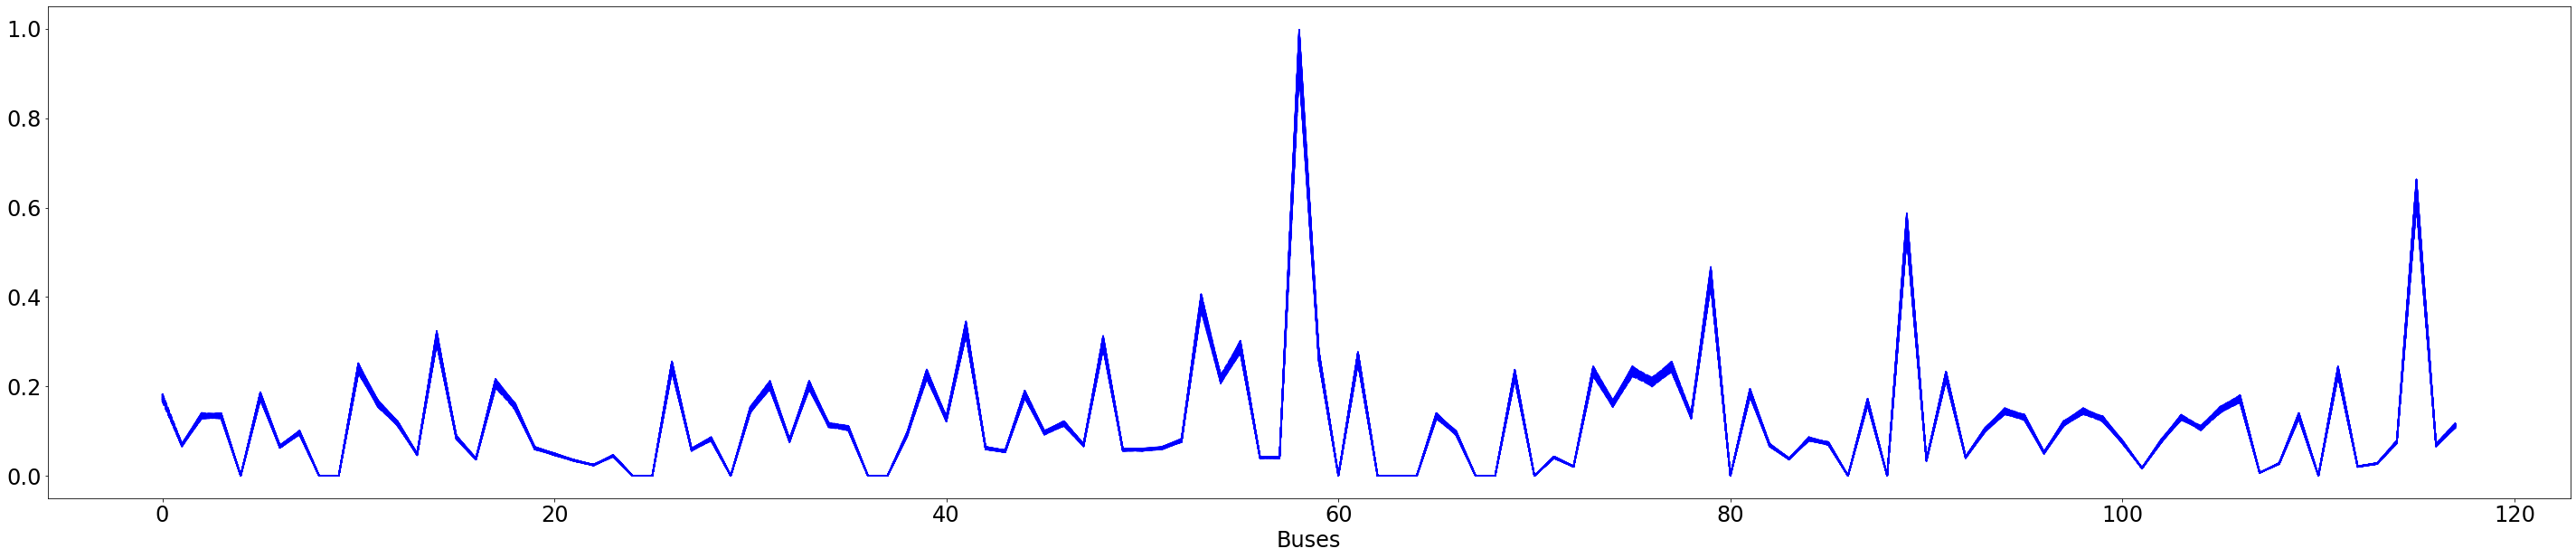

In [25]:
fig = plt.figure(figsize=(50,10))
Xrange = np.array(range(N))
for i in range(100):
    # plt.bar(Xrange, pretrain_dataset[i,:], width = 0.5, color ='maroon')
    plt.plot(Xrange, pretrain_dataset[i,:]/np.max(pretrain_dataset), 'b--', markersize=10)
# plt.legend(fontsize=24)
plt.xlabel('Buses', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

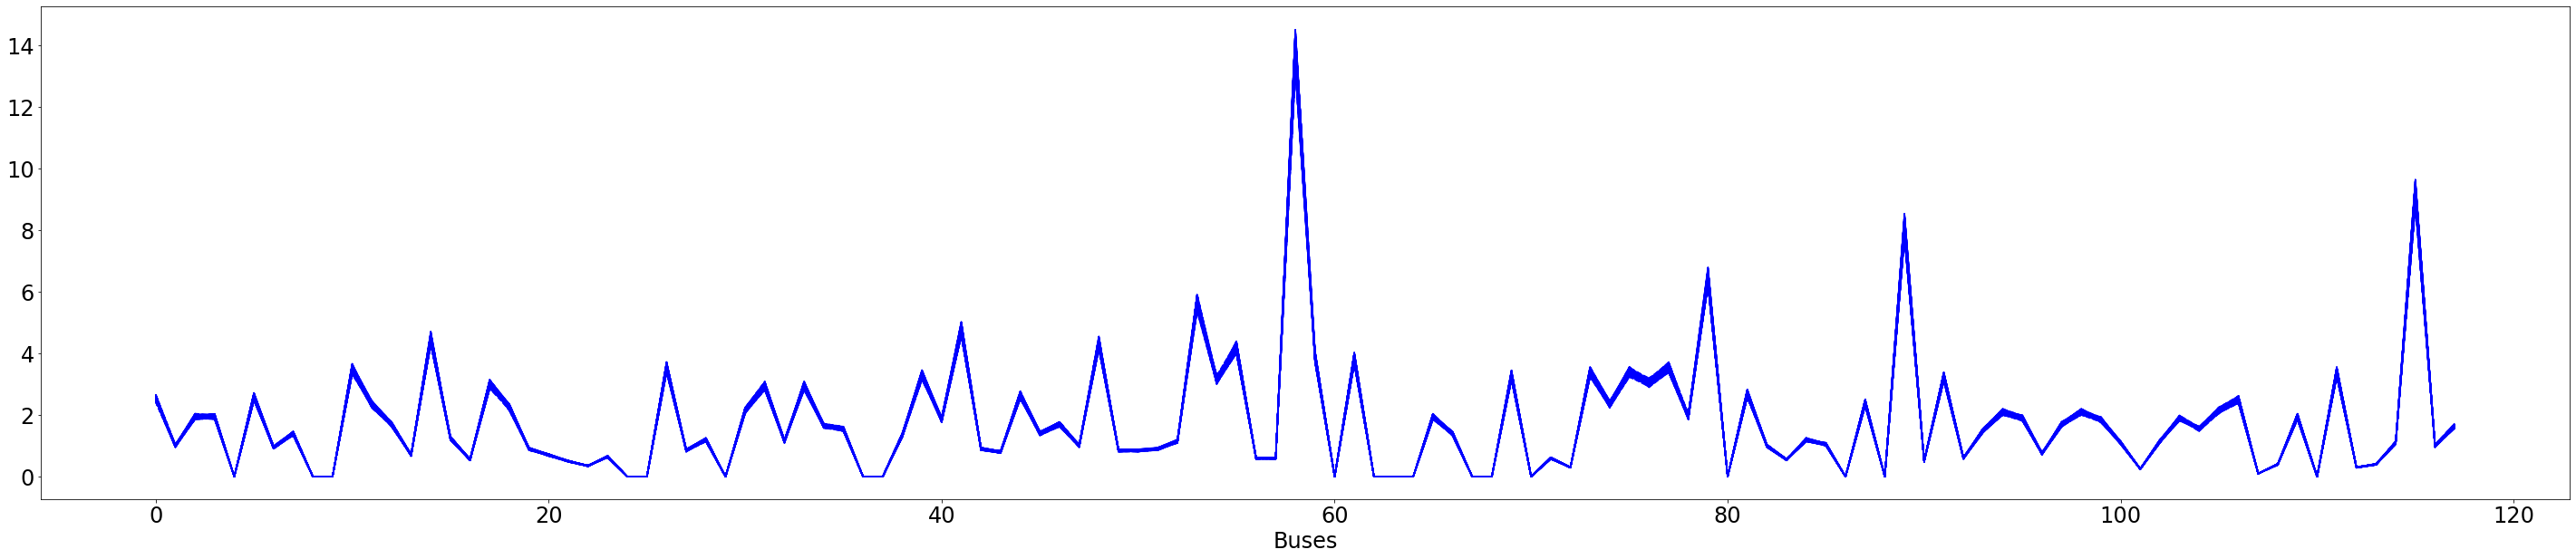

In [26]:
fig = plt.figure(figsize=(50,10))
Xrange = np.array(range(N))
for i in range(100):
    # plt.bar(Xrange, pretrain_dataset[i,:], width = 0.5, color ='maroon')
    plt.plot(Xrange, pretrain_dataset[i,:], 'b--', markersize=10)
# plt.legend(fontsize=24)
plt.xlabel('Buses', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

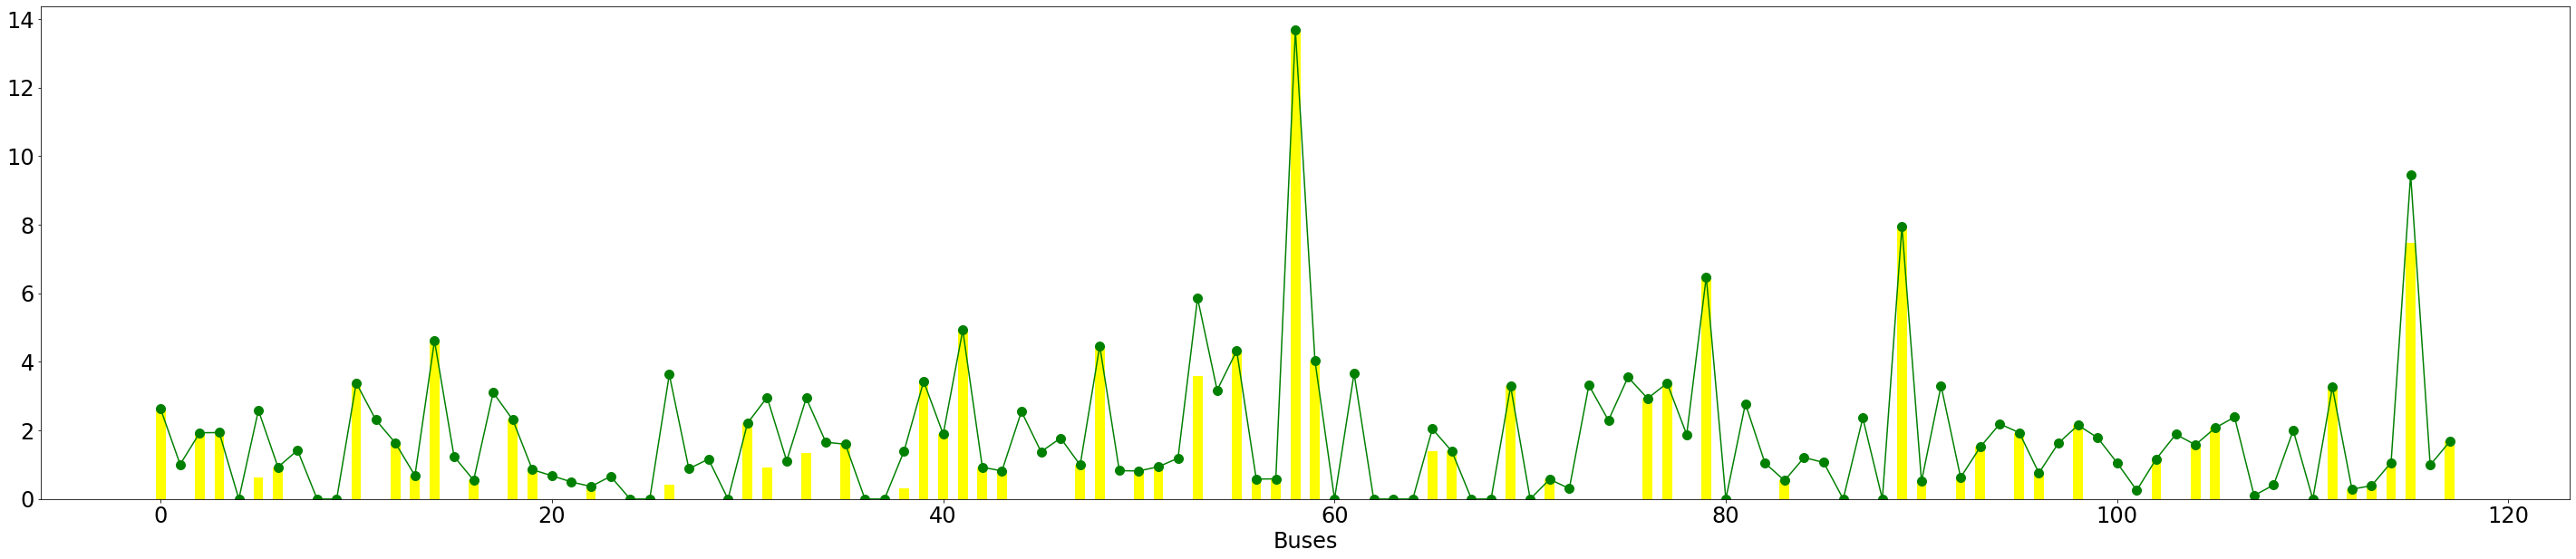

In [27]:
fig = plt.figure(figsize=(50,10))
Xrange = np.array(range(N))

plt.plot(Xrange, pretrain_dataset[80,:], 'g-o', markersize=10)
plt.bar(Xrange, x_true[80,:], width = 0.5, color ='yellow')

# plt.plot(Xrange, pretrain_dataset[50,:], 'b-s', markersize=10)
# plt.plot(Xrange, pretrain_dataset[99,:], 'y-D', markersize=10)
# plt.legend(fontsize=24)
plt.xlabel('Buses', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

### Supervised learning training process

In [95]:
def train_action(dataset, num_epochs, batch_size, yplot = 'plain'):

    def plot_train_loss(train_hist, epoch):
        print('len:', len(train_hist['train_losses']))

        fig = plt.figure(figsize=(10,10))
        plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
        ax = fig.add_subplot(1, 1, 1)
        if yplot == 'log10':
            ax.plot(range(len(train_hist['train_losses'])), np.log10(train_hist['train_losses']), label='train loss')
            ax.set_ylabel('log10(train loss)',fontsize=20)
        elif yplot == 'plain':
            ax.plot(range(len(train_hist['train_losses'])), train_hist['train_losses'], label='train loss')
            ax.set_ylabel('train loss',fontsize=20)
        ax.set_xlabel('training epochs',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig(saved_path+str(epoch)+'train_losses_sl.png')


    # Set learning rates
    lr = 0.0001

    # Build models or load models
    # action_net, reward_net = load_saved_models()
    action_net = ActionNet(N, 256, N)
    
    # action_net.load_state_dict(torch.load(saved_path+'trained_action_net_sl.pt'))

    # return action_net

    # Configure optimizers
    action_optim = optim.Adam(action_net.parameters(), lr=lr, betas=(0.5, 0.999))

    loss_criterion = nn.MSELoss()

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_hist = {}
    train_hist['train_losses'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    num_iter = 0

    print('Training starts!')
    start_time = time.time()

    for epoch in range(num_epochs):
        train_losses = []
        epoch_start_time = time.time()

        for batch in train_loader:

            ## zero grad
            action_net.zero_grad()

            ## get a batch of data
            input = batch.float()
            load = input[:, :N]
            target = input[:, N:]

            x_pred = action_net(load)
            # print('x_pred:', x_pred.shape)
            # print('target:', target.shape)
            # print('x_pred:', x_pred.detach().numpy()[0,:5])
            # print('target:', target.detach().numpy()[0,:5])

            train_loss = loss_criterion(x_pred*np.max(pretrain_dataset), target*np.max(pretrain_dataset))

            train_loss.backward(retain_graph=True)
            action_optim.step()
            # reward_optim.step()

            train_losses.append(train_loss.item())


            num_iter += 1

            if num_iter % 2000 == 0:
                print('[%d/%d], loss: %.5f' % ((epoch + 1), 
                    (num_iter + 1), 
                    torch.FloatTensor(train_losses).mean().item()))
                    
        epoch_end_time = time.time()
        per_epoch_time = epoch_end_time - epoch_start_time

        loss_value = torch.mean(torch.FloatTensor(train_losses)).item()

        train_hist['train_losses'].append(round(loss_value, 4))
        train_hist['per_epoch_time'].append(per_epoch_time)
                
        if epoch > 0 :
            if epoch % 20000 == 0 or epoch == num_epochs-1:

                torch.save(action_net.state_dict(), saved_path+'trained_action_net_sl.pt')

                # torch.save(reward_net.state_dict(), saved_path+'trained_reward_net.pt')

                plot_train_loss(train_hist, epoch)
                
    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Avg per epoch time: %.2f, total %d epochs time: %.2f" % \
        (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), num_epochs, total_time))
    print("Training finish!")

    print(len(train_hist['train_losses']))

    # End training loop

    return action_net


#### Pretrain action net

Training starts!
[23/2001], loss: 0.08200
[45/4001], loss: 0.05926
[67/6001], loss: 0.03493
[89/8001], loss: 0.02929
[112/10001], loss: 0.02164
[134/12001], loss: 0.02728
[156/14001], loss: 0.02012
[178/16001], loss: 0.01598
[200/18001], loss: 0.01573
[223/20001], loss: 0.01612
[245/22001], loss: 0.01665
[267/24001], loss: 0.01430
[289/26001], loss: 0.01445
[312/28001], loss: 0.01428
[334/30001], loss: 0.01483
[356/32001], loss: 0.01637
[378/34001], loss: 0.01385
[400/36001], loss: 0.01392
[423/38001], loss: 0.01697
[445/40001], loss: 0.01425
[467/42001], loss: 0.01254
[489/44001], loss: 0.01317
[512/46001], loss: 0.01131
[534/48001], loss: 0.01237
[556/50001], loss: 0.01140
[578/52001], loss: 0.01293
[600/54001], loss: 0.01304
[623/56001], loss: 0.01299
[645/58001], loss: 0.01149
[667/60001], loss: 0.01143
[689/62001], loss: 0.01120
[712/64001], loss: 0.01159
[734/66001], loss: 0.01136
[756/68001], loss: 0.01054
[778/70001], loss: 0.01077
[800/72001], loss: 0.01074
[823/74001], loss: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


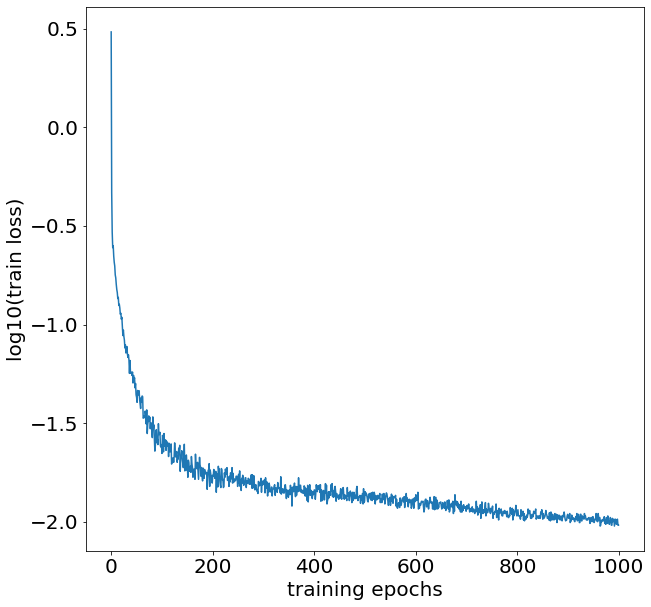

In [96]:
# trained_action_net = train_action(TrainDataset(X_train[:1,:]), num_epochs=1, batch_size=1,
#                                                yplot = 'log10')
trained_action_net = train_action(TrainDataset(X_train), num_epochs=1000, batch_size=1,
                                               yplot = 'log10')

In [97]:
def test_neural_policy(dataset, trained_model):

    trained_model.eval()

    with torch.no_grad():

        input = torch.tensor(dataset).float()

        x_pred = trained_model(input[:,:N])

        return x_pred.detach().numpy()*np.max(pretrain_dataset )

In [98]:
x_pred = test_neural_policy(test_dataset/np.max(pretrain_dataset), trained_action_net)
# x_pred = test_neural_policy(X_test, trained_action_net)

<BarContainer object of 118 artists>

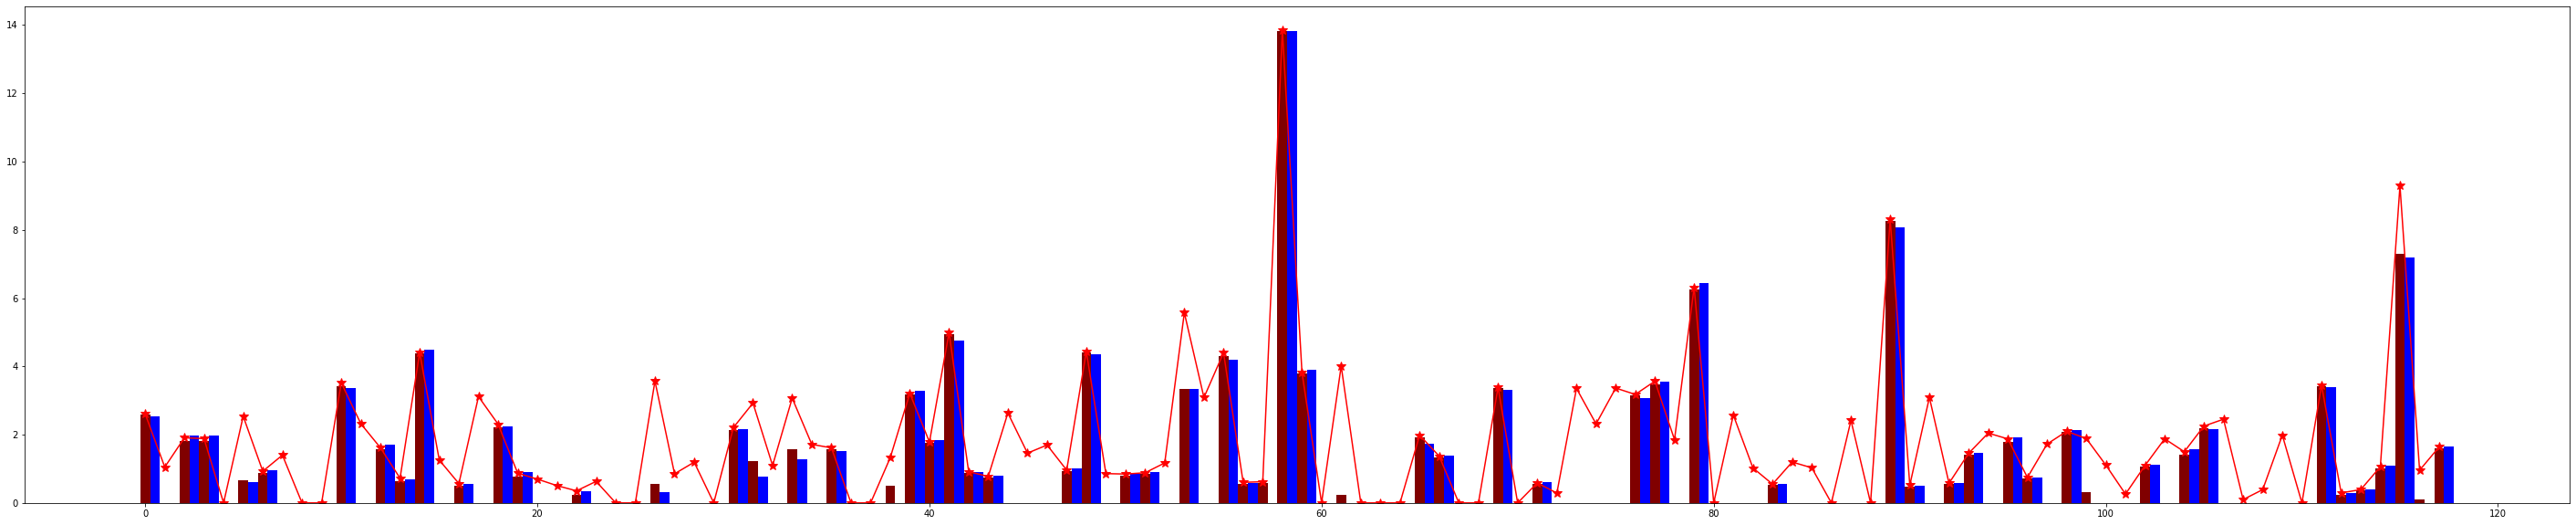

In [99]:
fig = plt.figure(figsize=(50,10))

Xrange = np.array(range(N))
plt.plot(Xrange, test_dataset[5,:N], 'r-*', markersize=10, label='forecast')
plt.bar(Xrange, x_cp[5,:], width = 0.5, color ='maroon',label='x_true')
plt.bar(Xrange+0.5, x_pred[5,:], width = 0.5, color ='blue',label='x_pred')

# plt.legend(fontsize=24)
# plt.xlabel('Buses', fontsize=24)
# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)

# plt.show()

Averaged relative error in x is 5.01%
Averaged relative error in c is 0.75%


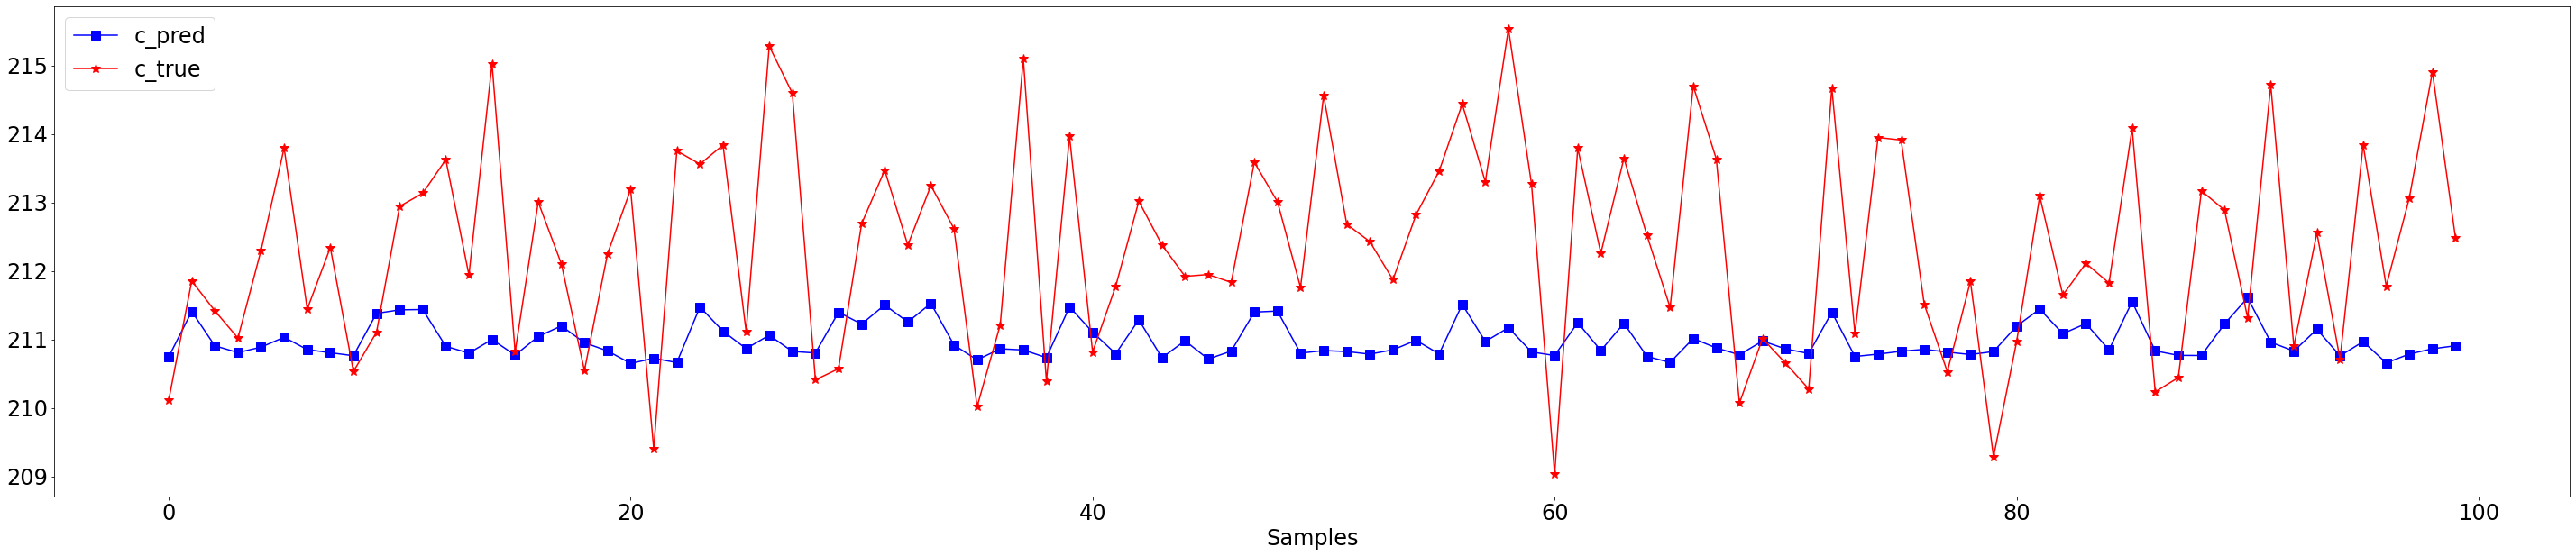

In [100]:
c_pred = x_pred@da_cost_Coeff
c_cp = x_cp@da_cost_Coeff

x_dist = measure_relative_distance(x_cp, x_pred)
c_dist = measure_relative_distance(c_cp, c_pred)

print('Averaged relative error in x is %.2f%%' % (x_dist*100))
print('Averaged relative error in c is %.2f%%' % (c_dist*100))

fig = plt.figure(figsize=(50,10))
# plt.plot(range(100), np.sum(test_dataset, axis=-1), 'y-D', markersize=10, label='total load')
# plt.plot(range(100), np.sum(x_pred, axis=-1), 'b-s', markersize=10, label='total x')
plt.plot(range(100), c_pred.flatten(), 'b-s', markersize=10, label='c_pred')
plt.plot(range(100), c_cp.flatten(), 'r-*', markersize=10, label='c_true')


plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

### Let's look at if the reward net has the scaling issue

### Define polytope (feasibilty set of theta)

In [101]:
G = np.block([
              [Arr],
              [-Arr],
              [np.eye(N-1)],
              [-np.eye(N-1)]
])
print('G shape:', G.shape)

G shape: (606, 117)


In [120]:
def train_reward(dataset, num_epochs, batch_size, yplot = 'plain'):

    def plot_train_loss(train_hist, epoch):
        print('len:', len(train_hist['train_losses']))

        fig = plt.figure(figsize=(10,10))
        plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
        ax = fig.add_subplot(1, 1, 1)
        if yplot == 'log10':
            ax.plot(range(len(train_hist['train_losses'])), np.log10(train_hist['train_losses']), label='train loss')
            ax.set_ylabel('log10(train loss)',fontsize=20)
        elif yplot == 'plain':
            ax.plot(range(len(train_hist['train_losses'])), train_hist['train_losses'], label='train loss')
            ax.set_ylabel('train loss',fontsize=20)
        ax.set_xlabel('training epochs',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig(saved_path+str(epoch)+'train_losses_sl.png')


    # Set learning rates
    lr = 0.0001

    # Build models or load models
    # action_net, reward_net = load_saved_models()
    reward_net = RewardNet(N, 256, N-1)

    # reward_net.load_state_dict(torch.load(saved_path+'trained_reward_net_sl.pt'))

    # return reward_net
    

    # Configure optimizers
    reward_optim = optim.Adam(reward_net.parameters(), lr=lr, betas=(0.5, 0.999))

    loss_criterion = nn.MSELoss()

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_hist = {}
    train_hist['train_losses'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    num_iter = 0

    print('Training starts!')
    start_time = time.time()


    G_ts = torch.tensor(G).float()
    B_ts = torch.tensor(-Yrr).float()
    F_ts = torch.tensor(Arr).float()
    q_ts = torch.tensor(linear_cost_Coeff).float()
    c_ts = torch.tensor(da_cost_Coeff).float()

    for epoch in range(num_epochs):
        train_losses = []
        epoch_start_time = time.time()

        for batch in train_loader:

            ## zero grad
            reward_net.zero_grad()

            ## get a batch of data
            input = batch.float()
            q_input = input[:, :N]
            target = input[:, N:N+N-1]
            y_target = input[:, N+N-1:N+N-1+N]
            Q_target = input[:, N+N-1+N:]

            pred = reward_net(q_input)

            # net_d = q_input*max_val
            net_d = q_input

            h_batch = torch.cat([
                                Fmax*torch.ones(L, input.shape[0]),
                                Fmax*torch.ones(L, input.shape[0]),
                                np.pi*torch.ones(N-1, input.shape[0]),
                                np.pi*torch.ones(N-1, input.shape[0])
                                ],dim=0)

            h_batch_ts = torch.tensor(h_batch).float()
            
            ctr_ts = torch.zeros((N-1, input.shape[0]))
            assert torch.max(G_ts@ctr_ts - h_batch_ts)< 0.0, "Caution: v0 is not a feasible point."

            # Use ctr_ts to shift the feasible set Gv<=H
            h_shift = h_batch_ts - G_ts@ctr_ts
            assert torch.min(h_shift) > 0.0, "Caution: origin is not an interior point"

            # Use gauge mapping to transform output to feas_output

            feas_pred = gauge_map(pred.T, G_ts, h_shift) + ctr_ts

            y_pred = F.relu(-B_ts@feas_pred + net_d.T) # (N, batch_size)
            Q_pred = y_pred.T@q_ts

            # train_loss = loss_criterion(feas_pred.T, target) +\
                        # loss_criterion(y_pred.T, y_target) 
            train_loss = loss_criterion(feas_pred.T, target)
            # train_loss = loss_criterion(Q_pred, Q_target) 

            train_loss.backward(retain_graph=True)
            reward_optim.step()
            # reward_optim.step()

            train_losses.append(train_loss.item())


            num_iter += 1

            if num_iter % 10000 == 0:
                print('[%d/%d], loss: %.5f' % ((epoch + 1), 
                    (num_iter + 1), 
                    torch.FloatTensor(train_losses).mean().item()))
                    
        epoch_end_time = time.time()
        per_epoch_time = epoch_end_time - epoch_start_time

        loss_value = torch.mean(torch.FloatTensor(train_losses)).item()

        train_hist['train_losses'].append(round(loss_value, 4))
        train_hist['per_epoch_time'].append(per_epoch_time)
                
        if epoch > 0 :
            if epoch % 100000 == 0 or epoch == num_epochs-1:

                torch.save(reward_net.state_dict(), saved_path+'trained_reward_net_sl.pt')

                # torch.save(reward_net.state_dict(), saved_path+'trained_reward_net.pt')

                plot_train_loss(train_hist, epoch)
                
    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Avg per epoch time: %.2f, total %d epochs time: %.2f" % \
        (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), num_epochs, total_time))
    print("Training finish!")

    print(len(train_hist['train_losses']))

    # End training loop

    return reward_net


#### Pretrain reward net

Training starts!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[112/10001], loss: 0.02280
[223/20001], loss: 0.01486
[334/30001], loss: 0.01665
[445/40001], loss: 0.01192
[556/50001], loss: 0.00965
[667/60001], loss: 0.00671
[778/70001], loss: 0.00699
[889/80001], loss: 0.00480
[1000/90001], loss: 0.00685
[1112/100001], loss: 0.00456
[1223/110001], loss: 0.00374
[1334/120001], loss: 0.00467
[1445/130001], loss: 0.00290
[1556/140001], loss: 0.00366
[1667/150001], loss: 0.00279
[1778/160001], loss: 0.00410
[1889/170001], loss: 0.00372
[2000/180001], loss: 0.00525
len: 2000
Avg per epoch time: 0.55, total 2000 epochs time: 1093.60
Training finish!
2000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


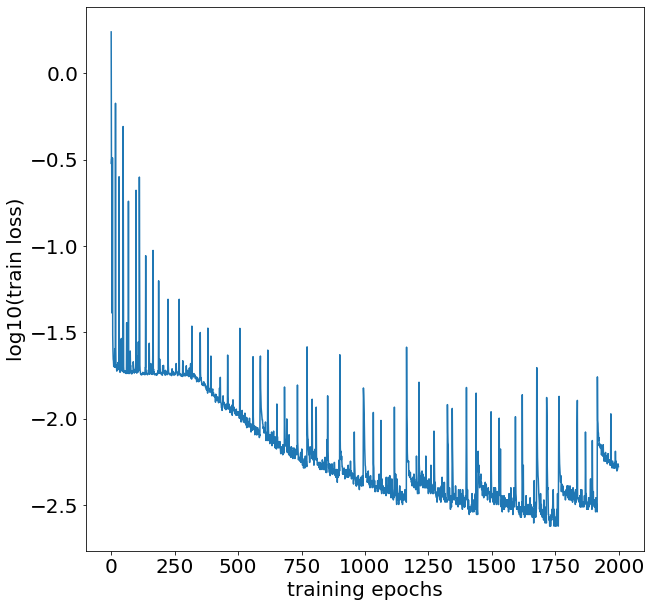

In [121]:
# trained_reward_net = train_reward(TrainDataset(X_train2[:1,:]), num_epochs=20, batch_size=1,
#                                                yplot = 'log10')
trained_reward_net = train_reward(TrainDataset(X_train2), num_epochs=2000, batch_size=1,
                                               yplot = 'log10')

In [122]:
def test_reward_net(dataset, trained_net):

    # _, reward_net = load_saved_models()

    trained_net.eval()

    with torch.no_grad():
        G_ts = torch.tensor(G).float()
        B_ts = torch.tensor(-Yrr).float()
        q_ts = torch.tensor(linear_cost_Coeff).float()

        input = torch.tensor(dataset).float()

        q_input = input[:, :N]

        pred = trained_net(q_input)

        # net_d = q_input*max_val
        net_d = q_input

        h_batch = torch.cat([
                            Fmax*torch.ones(L, input.shape[0]),
                            Fmax*torch.ones(L, input.shape[0]),
                            np.pi*torch.ones(N-1, input.shape[0]),
                            np.pi*torch.ones(N-1, input.shape[0])
                            ],dim=0)

        h_batch_ts = torch.tensor(h_batch).float()
        
        ctr_ts = torch.zeros((N-1, input.shape[0]))
        assert torch.max(G_ts@ctr_ts - h_batch_ts)< 0.0, "Caution: v0 is not a feasible point."

        # Use ctr_ts to shift the feasible set Gv<=H
        h_shift = h_batch_ts - G_ts@ctr_ts
        assert torch.min(h_shift) > 0.0, "Caution: origin is not an interior point"

        # Use gauge mapping to transform output to feas_output

        feas_pred = gauge_map(pred.T, G_ts, h_shift) + ctr_ts

        y_pred = F.relu(-B_ts@feas_pred + net_d.T) # (N, batch_size)
        Q_pred = y_pred.T@q_ts


    return feas_pred.detach().numpy().T, y_pred.detach().numpy().T, Q_pred.detach().numpy()


In [109]:
print(max_val)

1.0


In [123]:
v_pred, y_pred, Q_pred = test_reward_net((test_dataset-x_pred)/max_val, trained_reward_net)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [124]:
def static_dcopf(forecast, x):

    v = cp.Variable((N-1,1))
    y = cp.Variable((N, 1))

    constraints_list = []

    q_input = cp.pos(forecast - x) 

    constraints_list.append( y >= Yrr@v + q_input )
        
    constraints_list.append( Arr@v <= Fmax*np.ones((num_lines, 1)))
    constraints_list.append( Arr@v >= -Fmax*np.ones((num_lines, 1)))

    constraints_list.append( v<=np.pi)
    constraints_list.append( v>=-np.pi)
    constraints_list.append( y>=0)

    Q_pred = y.T@linear_cost_Coeff
    prob = cp.Problem(cp.Minimize( Q_pred ), constraints_list)
   
    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return v.value, y.value, prob.value

In [125]:
def solve_batch_dcopf(dataset, x_pred):

    v_vals = []
    y_vals = []
    Q_vals = []

    for i in range(dataset.shape[0]):
        forecast = test_dataset[i,:].reshape(-1,1)
        x_val = x_pred[i,:].reshape(-1,1)

        v, y, Q = static_dcopf(forecast, x_val)

        v_vals.append(v.flatten())
        y_vals.append(y.flatten())
        Q_vals.append(Q)

    v_vals = np.array(v_vals)
    y_vals = np.array(y_vals)
    Q_vals = np.array(Q_vals)


    return v_vals, y_vals, Q_vals

In [126]:
v_, y_, Q_ = solve_batch_dcopf(test_dataset, x_pred)

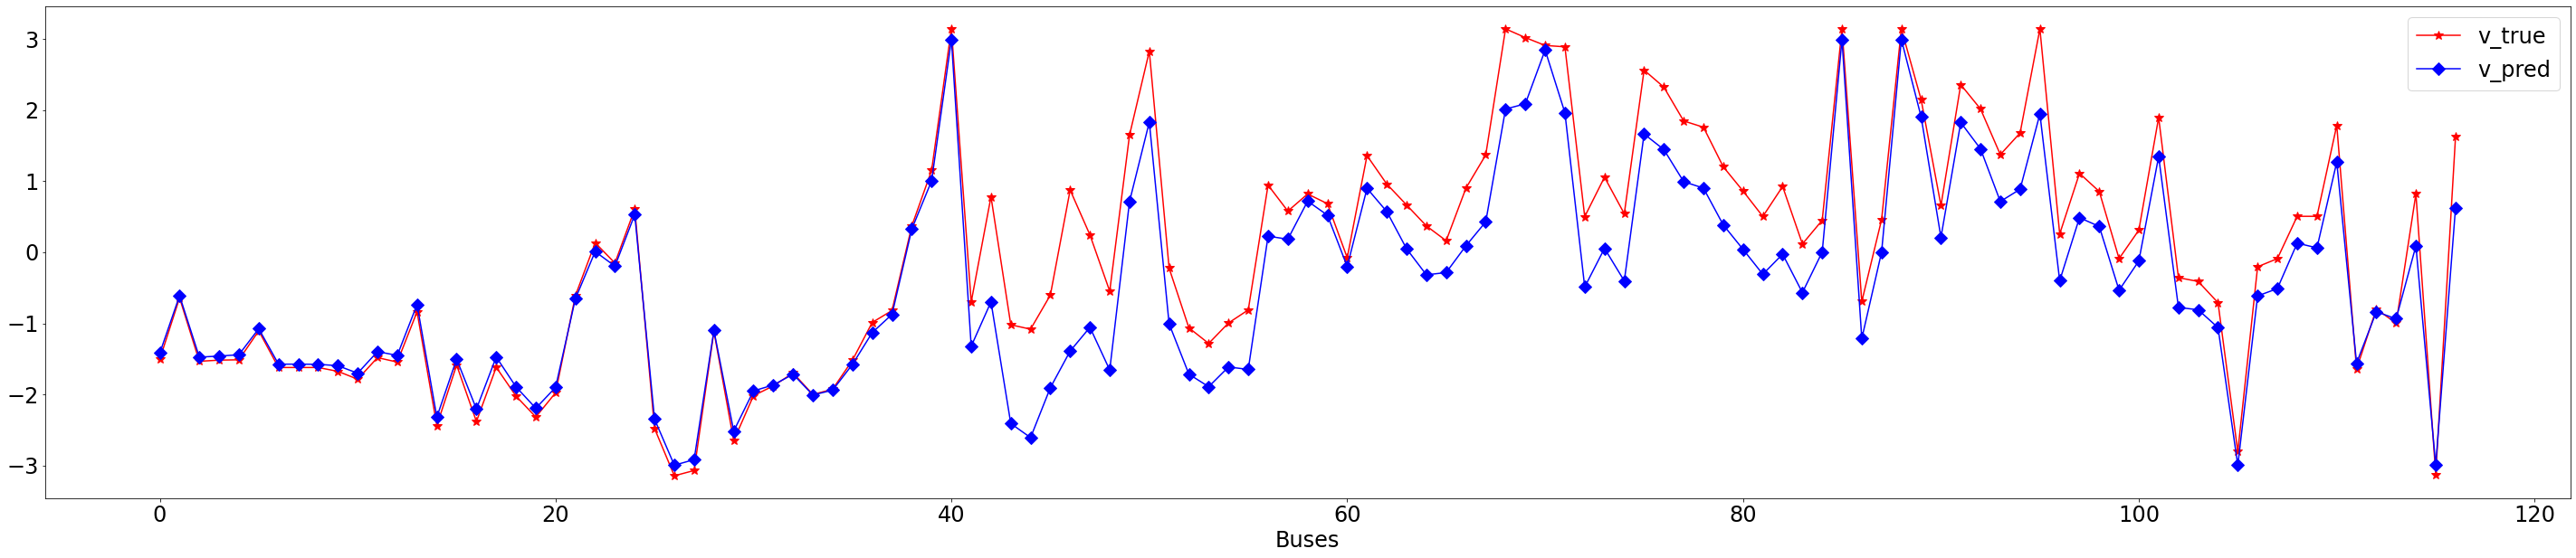

In [127]:
fig = plt.figure(figsize=(50,10))

Xrange = np.array(range(N-1))
plt.plot(Xrange, v_[5,:], 'r-*', markersize=10, label='v_true')
plt.plot(Xrange, v_pred[5,:], 'b-D', markersize=10, label='v_pred')

plt.legend(fontsize=24)
plt.xlabel('Buses', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

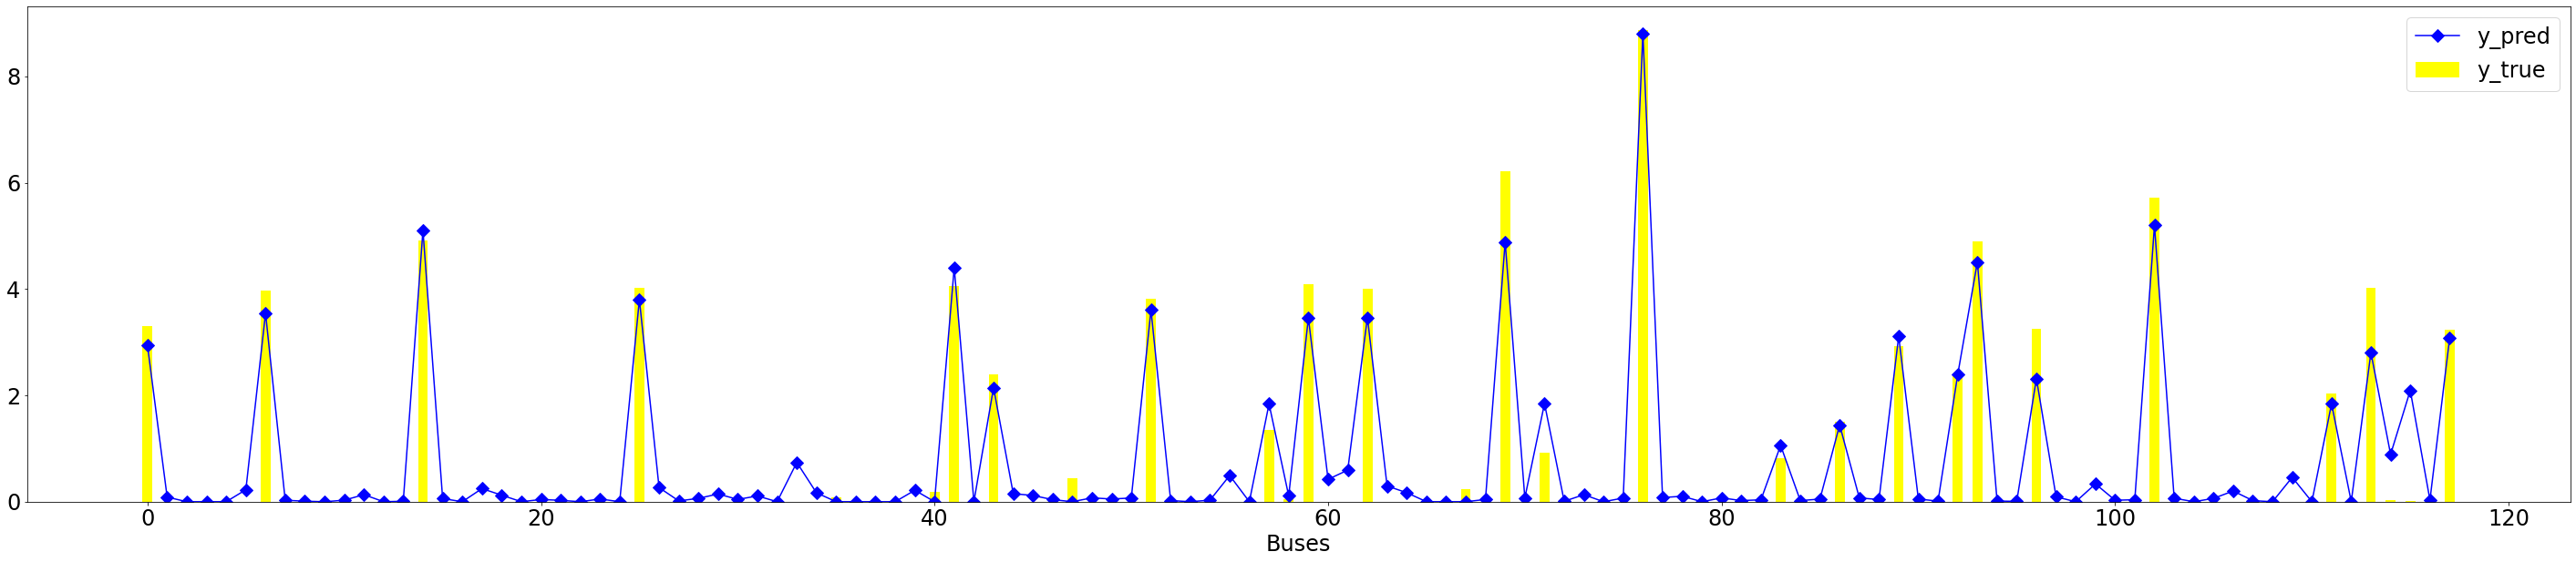

In [128]:
fig = plt.figure(figsize=(50,10))

Xrange = np.array(range(N))
plt.bar(Xrange, y_cp[5,:], width = 0.5, color ='yellow', label='y_true')
plt.plot(Xrange, y_pred[5,:], 'b-D', markersize=10, label='y_pred')

plt.legend(fontsize=24)
plt.xlabel('Buses', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

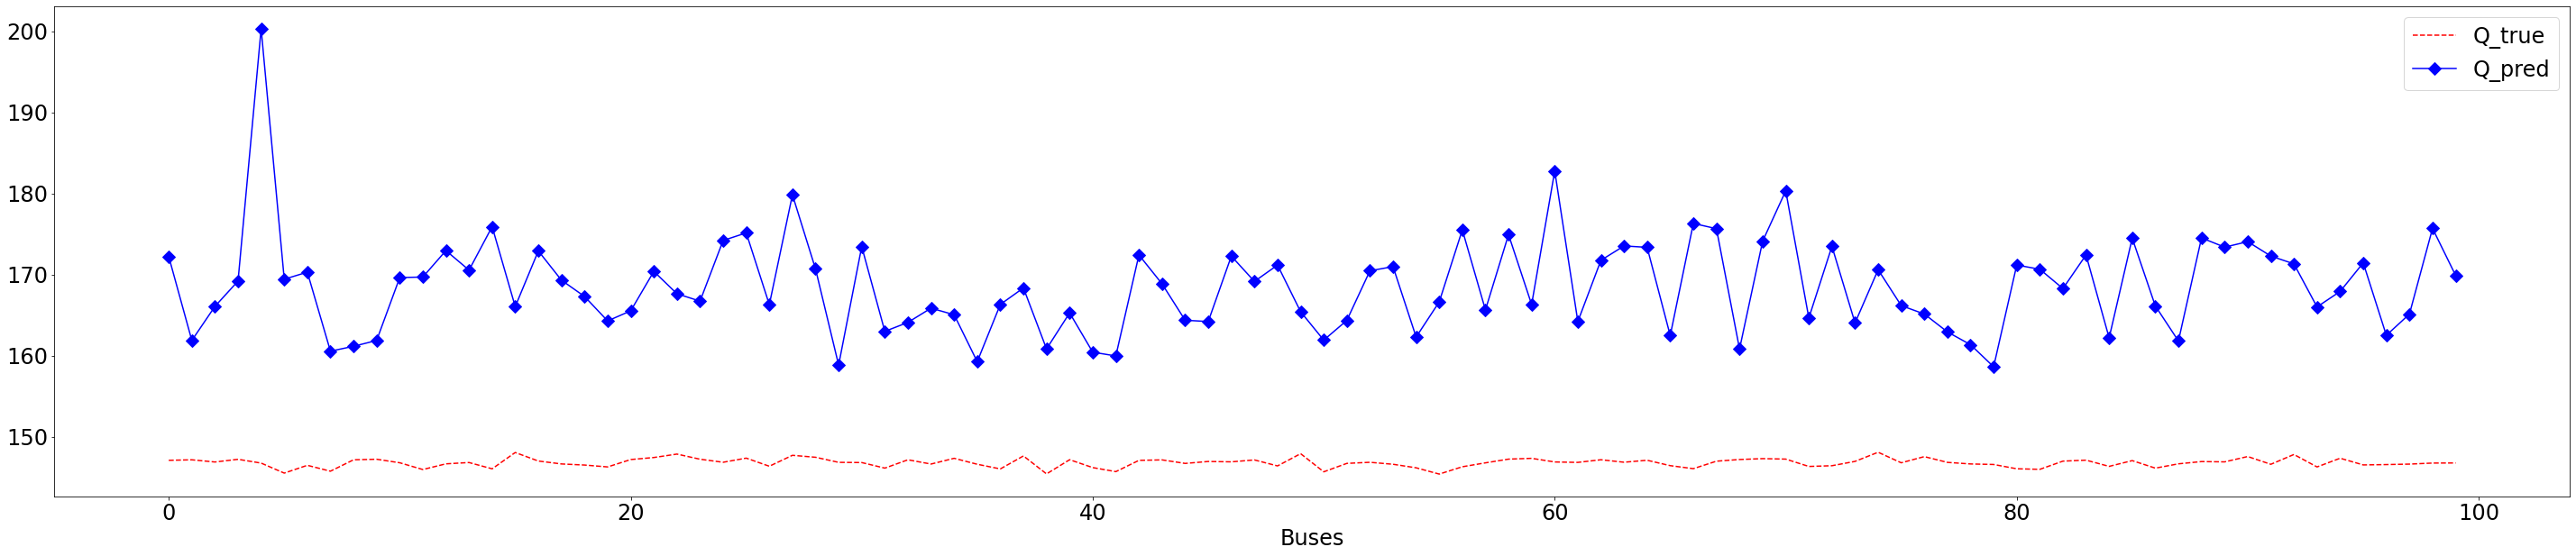

In [129]:
fig = plt.figure(figsize=(50,10))

Xrange = np.array(range(100))
plt.plot(Xrange, Q_cp.flatten(), 'r--', markersize=10, label='Q_true')
plt.plot(Xrange, Q_pred.flatten(), 'b-D', markersize=10, label='Q_pred')

plt.legend(fontsize=24)
plt.xlabel('Buses', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

# Unsupervised training

In [130]:
def load_saved_models():
    action_net = ActionNet(N, 256, N)
    action_net.load_state_dict(torch.load(saved_path+'trained_action_net.pt'))
    # action_net.eval()

    reward_net = RewardNet(N, 256, N-1)
    reward_net.load_state_dict(torch.load(saved_path+'trained_reward_net.pt'))
    # reward_net.eval()


    return action_net, reward_net

def load_pretrain_models():
    action_net = ActionNet(N, 256, N)
    action_net.load_state_dict(torch.load(saved_path+'trained_action_net_sl.pt'))
    # action_net.eval()

    reward_net = RewardNet(N, 256, N-1)
    reward_net.load_state_dict(torch.load(saved_path+'trained_reward_net_sl.pt'))
    # reward_net.eval()


    return action_net, reward_net

In [ ]:
print(max_input_val)
print(max_val)

In [131]:
def train(dataset, num_epochs, num_sce, batch_size, yplot = 'plain'):

    def plot_train_loss(train_hist, epoch):
        print('len:', len(train_hist['train_losses']))

        fig = plt.figure(figsize=(10,10))
        plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
        ax = fig.add_subplot(1, 1, 1)
        if yplot == 'log10':
            ax.plot(range(len(train_hist['train_losses'])), np.log10(train_hist['train_losses']), label='train loss')
            ax.set_ylabel('log10(train loss)',fontsize=20)
        elif yplot == 'plain':
            ax.plot(range(len(train_hist['train_losses'])), train_hist['train_losses'], label='train loss')
            ax.set_ylabel('train loss',fontsize=20)
        ax.set_xlabel('training epochs',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig(saved_path+str(epoch)+'train_losses.png')


    # Set learning rates
    lr = 0.0001

    # Build models or load models
    action_net, reward_net = load_pretrain_models()

    action_net.train(True)
    reward_net.train(True)

    # return action_net, reward_net

    # action_net = ActionNet(N, 256, N)
    # reward_net = RewardNet(N, 256, N-1)

    # Configure optimizers
    action_optim = optim.Adam(action_net.parameters(), lr=lr, betas=(0.5, 0.999))
    reward_optim = optim.Adam(reward_net.parameters(), lr=lr, betas=(0.5, 0.999))


    # Constant Parameters
    G_ts = torch.tensor(G).float()
    B_ts = torch.tensor(-Yrr).float()
    q_ts = torch.tensor(linear_cost_Coeff).float()
    c_ts = torch.tensor(da_cost_Coeff).float()
    max_val_ts = torch.tensor(max_input_val).float()


    h_batch = torch.cat([
                        Fmax*torch.ones(L, batch_size),
                        Fmax*torch.ones(L, batch_size),
                        np.pi*torch.ones(N-1, batch_size),
                        np.pi*torch.ones(N-1, batch_size)
                        ],dim=0)

    h_batch_ts = torch.tensor(h_batch).float()

    ctr_ts = torch.zeros((num_buses-1, batch_size))
    assert torch.max(G_ts@ctr_ts - h_batch_ts)< 0.0, "Caution: v0 is not a feasible point."

    # Use ctr_ts to shift the feasible set Gv<=H
    h_shift = h_batch_ts - G_ts@ctr_ts
    assert torch.min(h_shift) > 0.0, "Caution: origin is not an interior point"

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_hist = {}
    train_hist['train_losses'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    num_iter = 0

    print('Training starts!')
    start_time = time.time()

    for epoch in range(num_epochs):
        train_losses = []
        epoch_start_time = time.time()

        for batch in train_loader:

             ## zero grad
            action_net.zero_grad()
            reward_net.zero_grad()

            ## get a batch of data
            input = batch.float()
            x = action_net(input)# this input has been scaled, so x is treated as scaled

            input_val = input.detach().numpy()
            
            Q_pred = 0.
            for m in range(num_sce):          
                if Pe == 'uniform':  
                    lb = np.clip((1-ratio)*input_val, a_min=0., a_max=None)
                    ub = (1+ratio)*input_val
                    rt_scenario = np.random.uniform(lb, ub, (input_val.shape[0], input_val.shape[1]))

                    noise_sc = rt_scenario - input_val
                    
                    q_input = F.relu(input - x + torch.tensor(noise_sc).float()) * max_input_val

                else:
                    net_input = (input - x) * max_input_val
                    noise_sc = sigma * torch.randn_like(net_input)
                    q_input = F.relu(net_input + noise_sc)

                pred = reward_net(q_input)

                net_d = q_input # (N, bsize)
                # net_d = net_d * max_net_val

                # Use gauge mapping to transform output to feas_output
                feas_pred = gauge_map(pred.T, G_ts, h_shift) + ctr_ts

                # Construct cost function
                y_pred = F.relu(-B_ts@feas_pred + net_d.T) # (N, batch_size)
                # quad_cost = torch.diagonal(y.T@C1_ts@y)
                linear_cost = y_pred.T@q_ts
                # rt_cost += quad_cost + linear_cost.flatten()
                Q_pred += linear_cost.flatten()

            Q_pred = Q_pred/num_sce

            x_pred = x*max_val_ts

            da_cost = x_pred@c_ts
            total_cost = Q_pred*1. + da_cost.flatten()

            train_loss = torch.mean(total_cost) 

            train_loss.backward(retain_graph=True)
            action_optim.step()
            reward_optim.step()

            train_losses.append(train_loss.item())


            num_iter += 1

            if num_iter % 5000 == 0:
                print('[%d/%d], loss: %.5f' % ((epoch + 1), 
                    (num_iter + 1), 
                    torch.FloatTensor(train_losses).mean().item()))
                
        epoch_end_time = time.time()
        per_epoch_time = epoch_end_time - epoch_start_time

        loss_value = torch.mean(torch.FloatTensor(train_losses)).item()

        train_hist['train_losses'].append(round(loss_value, 4))
        train_hist['per_epoch_time'].append(per_epoch_time)
                
        if epoch > 0 :
            if epoch % 200 == 0 or epoch == num_epochs-1:

                torch.save(action_net.state_dict(), saved_path+'trained_action_net.pt')

                torch.save(reward_net.state_dict(), saved_path+'trained_reward_net.pt')

                plot_train_loss(train_hist, epoch)
                
    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Avg per epoch time: %.2f, total %d epochs time: %.2f" % \
        (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), num_epochs, total_time))
    print("Training finish!")

    print(len(train_hist['train_losses']))

    # End training loop
    return action_net, reward_net


### Training process

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training starts!
[10/5001], loss: 366.93481
[20/10001], loss: 366.32022
[30/15001], loss: 365.90915
[40/20001], loss: 365.64105
[50/25001], loss: 365.42850
[60/30001], loss: 365.24274
[70/35001], loss: 365.14645
[80/40001], loss: 365.00366
[90/45001], loss: 364.91751
[100/50001], loss: 364.80518
len: 100
Avg per epoch time: 24.25, total 100 epochs time: 2425.32
Training finish!
100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


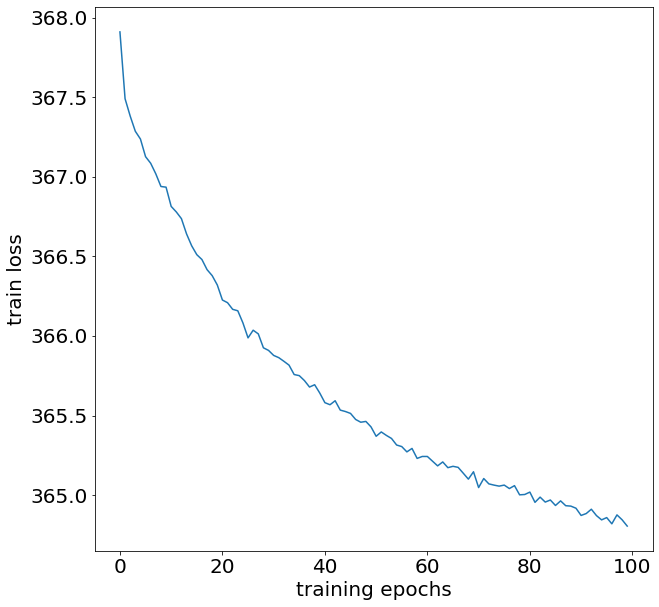

In [134]:
TrainFlag = True
if TrainFlag:
    trained_action_net, trained_reward_net = train(TrainSet, num_epochs=100, 
                                               num_sce=10, batch_size=100, 
                                               yplot = 'plain')
    
else:
    trained_action_net, trained_reward_net = load_saved_models()

# Use trained action net to make neural policy and evaluate using **cvxpy**

## Neural policy

In [135]:
def base_solver(forecast, x, num_sce):

    M = num_sce

    v = cp.Variable((N-1,M))
    y = cp.Variable((N, M))

    constraints_list = []

    for m in range(M):

        if Pe == 'uniform':
            lb = np.clip((1-ratio)*forecast, a_min=0., a_max=None)
            ub = (1+ratio)*forecast
            rt_scenario = np.random.uniform(lb, ub, (forecast.shape[0], forecast.shape[1]))
            q_input = np.clip(rt_scenario - x , a_min=0, a_max=None )

        else:

            net_input = forecast - x
            q_input = np.clip(net_input + sigma*np.random.randn(N, 1), a_min=0, a_max=None )
            assert np.min(q_input)>=0.0, 'np.clip does not work.'

        # q_input = net_input + 0.5*np.random.randn(N, 1) # of same size as x

        constraints_list.append( y[:,m:m+1] >= Yrr@v[:,m:m+1] + q_input )
        
    constraints_list.append( Arr@v <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@v >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( v<=np.pi)
    constraints_list.append( v>=-np.pi)
    constraints_list.append( y>=0)

    Q_vals = []
    for m in range(M):

        # total_cost += cp.quad_form(y[:,m:m+1], quad_cost_Coeff) + y[:,m:m+1].T@linear_cost_Coeff
        Q_vals.append(y[:,m:m+1].T@linear_cost_Coeff)

    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return prob.value, np.sum(y.value, axis=1)/M


def evaluate_policy(test_set, x_pred, num_sce):

    num_points = test_set.shape[0]

    Q_pred = []
    y_pred = []

    for i in range(num_points):
        forecast = test_set[i,:].reshape(-1,1)
        init_dispatch = x_pred[i,:].reshape(-1,1)

        Q_value, y_value = base_solver(forecast, init_dispatch, num_sce)

        Q_pred.append(Q_value)
        y_pred.append(y_value.flatten())
        

    Q_pred = np.array(Q_pred).reshape(-1,1)
    y_pred = np.array(y_pred)
    

    total_cost_pred = x_pred@da_cost_Coeff + Q_pred

    return total_cost_pred, Q_pred, y_pred

In [136]:
def apply_neural_policy(dataset, num_sce):

    action_net, _ = load_saved_models()

    action_net.eval()

    with torch.no_grad():

        input = torch.tensor(dataset).float()

        x = action_net(input)

        x_pred = x.detach().numpy()

        scaled_dataset = dataset*max_input_val
        scaled_x = x_pred*max_input_val

    total_cost_pred, Q_pred, y_pred = evaluate_policy(scaled_dataset, scaled_x, num_sce)
    
    return scaled_x, total_cost_pred, Q_pred, y_pred


In [137]:
def evaluate_neural_policy(runs=10):
    x_nu_pred = []
    J_nu_pred = []
    Q_nu_pred = []
    y_nu_pred = []

    for i in range(runs):

        x_pred, J_pred, Q_pred, y_pred = apply_neural_policy(test_dataset/max_input_val, num_sce=100)

        if i == 0:
            x_nu_pred = x_pred
            J_nu_pred = J_pred
            Q_nu_pred = Q_pred
            y_nu_pred = y_pred
        else:

            x_nu_pred += x_pred
            J_nu_pred += J_pred
            Q_nu_pred += Q_pred
            y_nu_pred += y_pred

    return x_nu_pred/runs, J_nu_pred/runs, Q_nu_pred/runs, y_nu_pred/runs

In [ ]:
x_nu_pred, J_nu_pred, Q_nu_pred, y_nu_pred = evaluate_neural_policy(runs=5)

In [ ]:
# J_pred, Q_pred, y_pred = evaluate_policy(test_dataset, x_pred, num_sce=100)

### Calculate relative distance between vectors for x, J and Q

In [139]:
x_dist2 = measure_relative_distance(x_cp, x_nu_pred)
J_dist2 = measure_relative_distance(J_cp, J_nu_pred)
Q_dist2 = measure_relative_distance(Q_cp, Q_nu_pred)

print('Averaged relative error in x is %.2f%%' % (x_dist2*100))
print('Averaged relative error in J is %.2f%%' % (J_dist2*100))
print('Averaged relative error in Q is %.2f%%' % (Q_dist2*100))

Averaged relative error in x is 4.96%
Averaged relative error in J is 0.43%
Averaged relative error in Q is 3.71%


## Affine policy

In [141]:
Pe = 'gaussian'
def affine_base_solver(forecast, num_sce):
    '''
    scenarios should be of size (N, M)

    '''
    M = num_sce

    c = da_cost_Coeff
    q = linear_cost_Coeff
    B = -Yrr
    F = Arr
    rho_lb = 10.
    rho_ub = 10.

    
    Phi = cp.Variable((N-1,N))
    theta0 = cp.Variable((N-1,1))

    x = cp.Variable((N, 1))

    net_input = forecast - x

    constraints_list = []
    sces = np.zeros_like(forecast)

    Q_vals = []

    for m in range(M):
        # for each scenario of noise

        if Pe == 'uniform':
            lb = np.clip((1-ratio)*forecast, a_min=0., a_max=None)
            ub = (1+ratio)*forecast
            rt_scenario = np.random.uniform(lb, ub, (forecast.shape[0], forecast.shape[1]))
            q_input = cp.pos(rt_scenario - x )

        else:
            rt_scenario = forecast + sigma*np.random.randn(N, 1)

            q_input = cp.pos(rt_scenario - x )

        noise_sce = rt_scenario - forecast

        theta_pred = Phi@noise_sce + theta0
        y_pred = cp.pos(q_input - B@theta_pred)
        # y_pred = q_input - B@theta_pred
        
        # constraints_list.append( F@theta_pred <= Fmax*np.ones((num_lines, 1)) )
        # constraints_list.append( F@theta_pred >= -Fmax*np.ones((num_lines, 1)) )

        # constraints_list.append( theta_pred<=np.pi)
        # constraints_list.append( theta_pred>=-np.pi)
        # constraints_list.append( y_pred>=0)

        p_f_lb = rho_lb*cp.norm( cp.pos(-Fmax*np.ones((num_lines, 1)) - F@theta_pred) )
        p_f_ub = rho_ub*cp.norm( cp.pos(F@theta_pred -Fmax*np.ones((num_lines, 1))) )

        p_v_lb  = rho_lb*cp.norm( cp.pos(-np.pi*np.ones((N-1, 1)) - theta_pred) )
        p_v_ub  = rho_ub*cp.norm( cp.pos(theta_pred - np.pi*np.ones((N-1, 1))) )

        Q_val = q.T@y_pred + p_f_lb + p_f_ub + p_v_lb + p_v_ub

        Q_vals.append(Q_val)

    constraints_list.append( x>=0)


    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( c.T@x + Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!  

    assert prob.status not in ["infeasible", "unbounded"], "Problem is not feasible or unbounded."


    return x.value.T, prob.value


def affine_solver(forecasts, num_sce):
    
    num_points = forecasts.shape[0]

    x_vals = []
    total_cost_vals = []

    for it in range(num_points):

        forecast = forecasts[it,:].reshape(-1,1)

        ## provide this set of scenarios and decide the value of x
        x_value, prob_value = affine_base_solver(forecast, num_sce)
    
        x_vals.append(x_value.flatten())
        total_cost_vals.append(prob_value)

    x_vals = np.array(x_vals)
    total_cost_vals = np.array(total_cost_vals).reshape(-1,1)

    return x_vals, total_cost_vals

In [142]:
def apply_affine_policy(dataset, num_sce):


    x_ap_pred,_ = affine_solver(dataset, 1)
    J_ap_pred, Q_ap_pred, y_ap_pred = evaluate_policy(dataset, x_ap_pred, num_sce)


    return x_ap_pred, J_ap_pred, Q_ap_pred, y_ap_pred

In [143]:
def evaluate_affine_policy(runs=10):
    x_ap_pred = []
    J_ap_pred = []
    Q_ap_pred = []
    y_ap_pred = []

    for i in range(runs):

        x_pred, J_pred, Q_pred, y_pred = apply_affine_policy(test_dataset, num_sce=100)

        if i == 0:
            x_ap_pred = x_pred
            J_ap_pred = J_pred
            Q_ap_pred = Q_pred
            y_ap_pred = y_pred
        else:

            x_ap_pred += x_pred
            J_ap_pred += J_pred
            Q_ap_pred += Q_pred
            y_ap_pred += y_pred

    return x_ap_pred/runs, J_ap_pred/runs, Q_ap_pred/runs, y_ap_pred/runs

In [144]:
EvalFlag = True
if EvalFlag == True:
    x_ap_pred, J_ap_pred, Q_ap_pred, y_ap_pred = evaluate_affine_policy(runs=1)

    np.save(saved_path+'x_ap_pred.npy', x_ap_pred)
    np.save(saved_path+'J_ap_pred.npy', J_ap_pred)
    np.save(saved_path+'Q_ap_pred.npy', Q_ap_pred)
    np.save(saved_path+'y_ap_pred.npy', y_ap_pred)

else:

    x_ap_pred = np.load(saved_path+'x_ap_pred.npy')
    J_ap_pred = np.load(saved_path+'J_ap_pred.npy')
    Q_ap_pred = np.load(saved_path+'Q_ap_pred.npy')
    y_ap_pred = np.load(saved_path+'y_ap_pred.npy')

### Calculate relative distance between vectors for x, J and Q

In [145]:
x_dist = measure_relative_distance(x_cp, x_ap_pred)
J_dist = measure_relative_distance(J_cp, J_ap_pred)
Q_dist = measure_relative_distance(Q_cp, Q_ap_pred)

print('Averaged relative error in x is %.2f%%' % (x_dist*100))
print('Averaged relative error in J is %.2f%%' % (J_dist*100))
print('Averaged relative error in Q is %.2f%%' % (Q_dist*100))

Averaged relative error in x is 3.86%
Averaged relative error in J is 0.53%
Averaged relative error in Q is 0.78%


## Plot

In [ ]:
c_nu_pred = x_nu_pred@da_cost_Coeff
c_ap_pred = x_ap_pred@da_cost_Coeff
c_cp = x_cp@da_cost_Coeff

fig = plt.figure(figsize=(50,10))
plt.plot(range(100), c_nu_pred.flatten(), 'b-s', markersize=10, label='c_nu_pred')
plt.plot(range(100), c_ap_pred.flatten(), 'y-D', markersize=10, label='c_ap_pred')
plt.plot(range(100), c_cp.flatten(), 'r-*', markersize=10, label='c_cp')


plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

In [ ]:
fig = plt.figure(figsize=(50,10))
plt.plot(range(100), Q_nu_pred.flatten(), 'b-s', markersize=10, label='Q_nu_pred')
plt.plot(range(100), Q_ap_pred.flatten(), 'y-D', markersize=10, label='Q_ap_pred')
plt.plot(range(100), Q_cp.flatten(), 'r-*', markersize=10, label='Q_cp')


plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

In [ ]:
fig = plt.figure(figsize=(50,10))
plt.plot(range(100), J_nu_pred.flatten(), 'b-s', markersize=10, label='J_nu_pred')
# plt.plot(range(100), J_ap_pred.flatten(), 'y-D', markersize=10, label='J_ap_pred')
plt.plot(range(100), J_cp.flatten(), 'r-*', markersize=10, label='J_cp')


plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

In [ ]:
fig = plt.figure(figsize=(50,10))


Xrange = np.array(range(N))
plt.plot(Xrange, test_dataset[62,:], 'r-*', markersize=10, label='forecast')
plt.bar(Xrange, x_cp[62,:], width = 0.5, color ='maroon',label='x_cp')
plt.bar(Xrange+0.5, x_nu_pred[62,:], width = 0.5, color ='blue',label='x_nu_pred')
# plt.bar(Xrange+1., x_ap_pred[62,:], width = 0.5, color ='yellow',label='x_ap_pred')

plt.legend(fontsize=24)
plt.xlabel('Buses', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()